In [1]:
from transformers import AutoTokenizer,AutoModelForCausalLM
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from captum.attr import (
    Saliency, 
    IntegratedGradients, 
    GradientShap,
    DeepLift,
    LayerIntegratedGradients
)
from numpy import random
import pandas as pd
import torch
from torch import nn, multinomial


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = AutoTokenizer.from_pretrained("../models/trained_moses_canonical_character_level/1/final_model")
model = AutoModelForCausalLM.from_pretrained("../models/trained_moses_canonical_character_level/1/final_model")
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(150, 256)
    (wpe): Embedding(60, 256)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-7): 8 x GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=768, nx=256)
          (c_proj): Conv1D(nf=256, nx=256)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=1024, nx=256)
          (c_proj): Conv1D(nf=256, nx=1024)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=256, out_features=150, bias=False)
)

In [22]:
def saliency_map_plot(scores,tokens,pred_token): 
    """if len(scores)>=3:
        scores = scores[1:len(scores)-1]
        tokens = tokens[1:len(tokens)-1]
"""
    max_score = torch.max(scores).item()  
    token_max_score_idx = []
    for k in range(len(scores)):
        if scores[k] >= 0.9*max_score:
            token_max_score_idx.append(k)
    tokens_adapted = ["" if k not in token_max_score_idx else tokens[k] for k in range(len(tokens)) ]
    fig, ax = plt.subplots(figsize=(20, 1))
   
    im = ax.imshow([scores.tolist()],cmap="viridis", data=tokens)
    ax.set_title('saliency map')
    fig.colorbar(im)

    plt.xticks([k for k in range(len(scores.tolist()))], tokens_adapted)

    ax.set_xlabel("saliency map for this token prediction : "+pred_token)

    

    
# 4. Forward personnalisé : utilise les embeddings au lieu de input_ids
def forward_func(embeds):
    outputs = model(inputs_embeds=embeds)
    # Prédiction du prochain token (dernier logit)
    return outputs.logits[:, -1, :]  # shape [1, vocab_size]


In [10]:
def compute_baseline_embeddings(inputs_embeds, method='random'):
    if method == 'random':
        return torch.randn_like(inputs_embeds) * 0.1
    if method == 'zero':
        return torch.zeros_like(inputs_embeds)
    else:
        raise ValueError(f"Méthode baseline inconnue: {method}")


In [16]:
generated_ids = model.generate(
    max_length = tokenizer.model_max_length,
    num_return_sequences =1,
    pad_token_id = tokenizer.pad_token_id,
    bos_token_id = tokenizer.bos_token_id,
    eos_token_id = tokenizer.eos_token_id,
    do_sample = True,
    temperature = 1,
    return_dict_in_generate = True,
)

generated_smiles = tokenizer.decode(generated_ids["sequences"][0],skip_special_tokens=True)
len(generated_ids["sequences"])
generated_smiles = generated_smiles.replace(" ","")
generated_smiles

'CC(=O)NCC(=O)NCC(=O)N1CCN(Cc2ccccc2)CC1)C1CC1'

/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)
/tmp/ipykernel_234150/1648491635.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(20, 1))


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Erreur : name 'dl_scores' is not defined


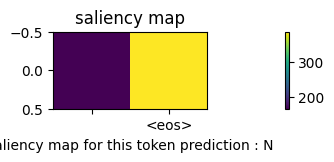

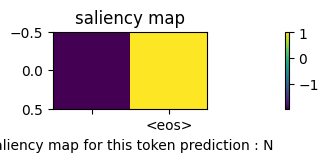

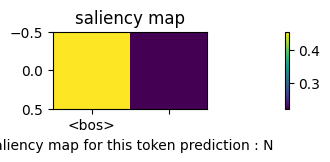

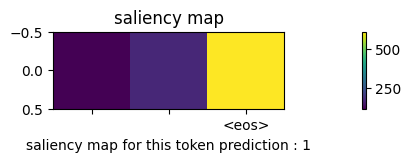

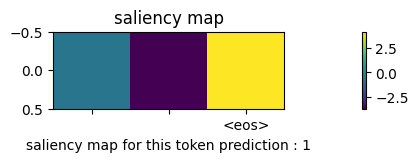

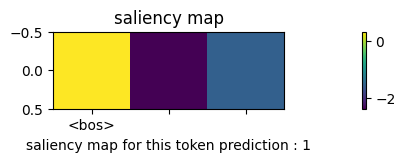

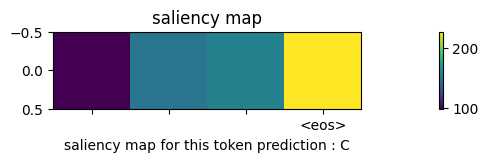

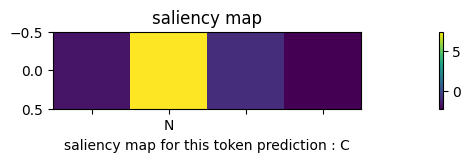

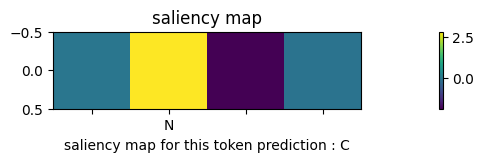

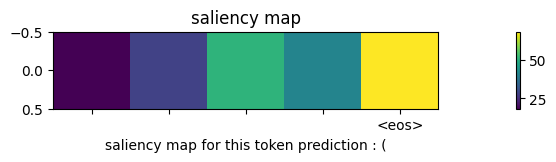

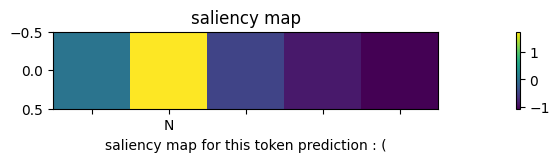

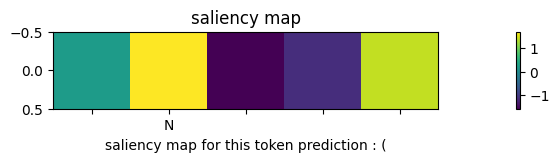

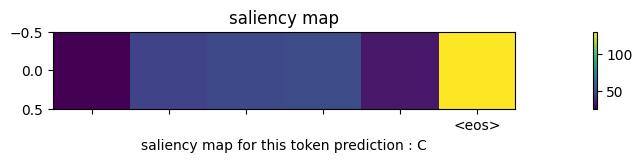

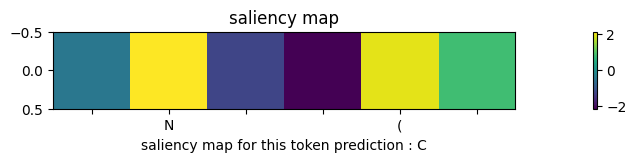

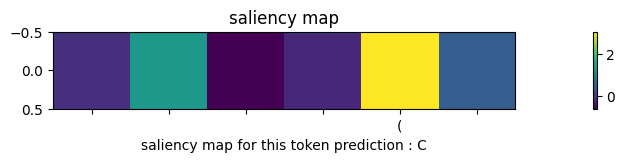

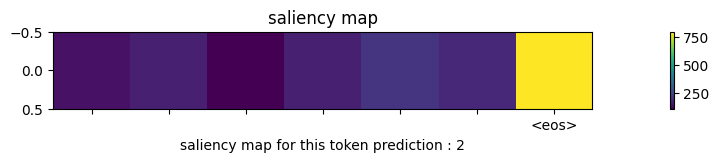

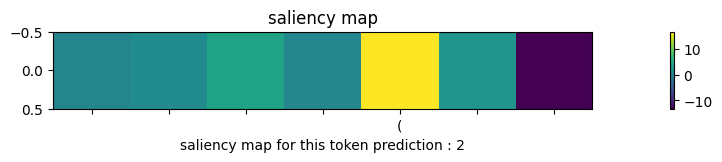

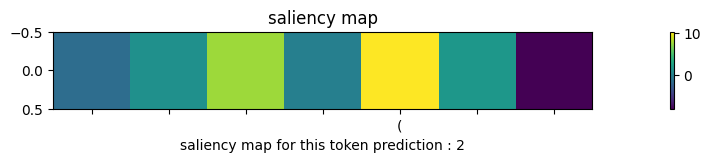

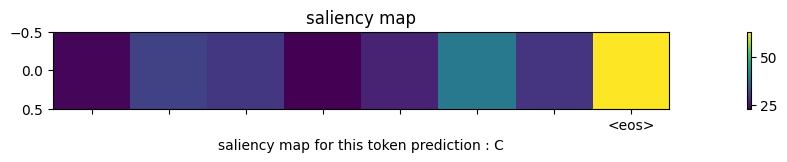

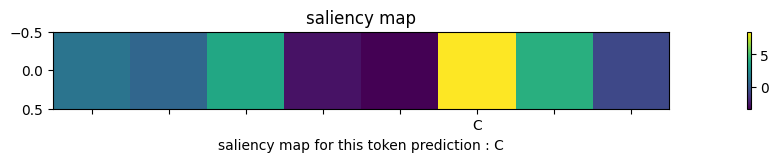

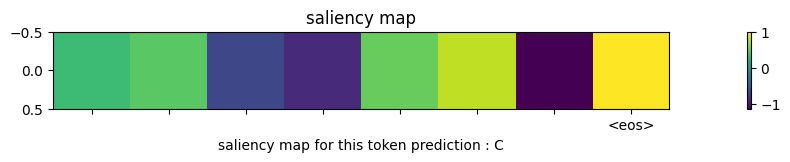

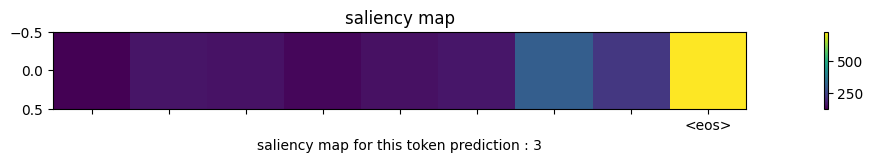

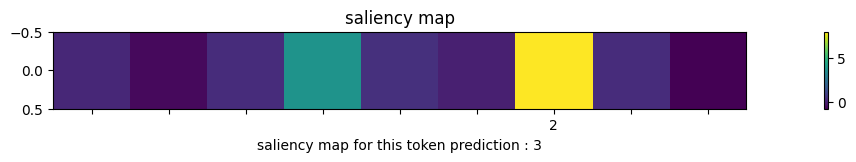

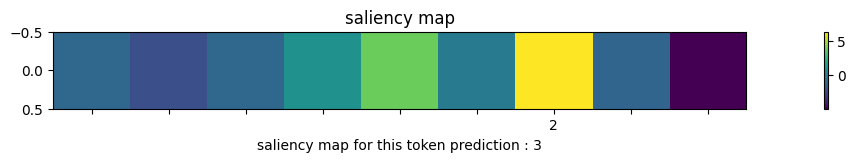

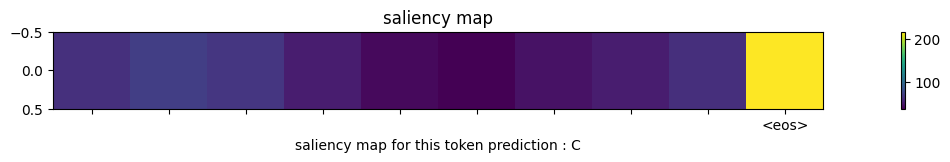

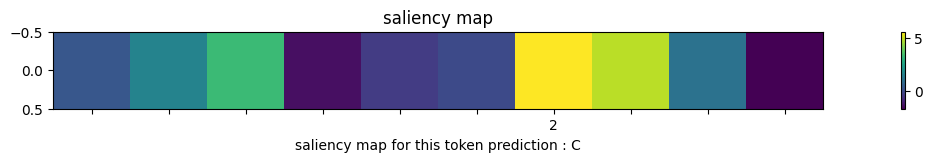

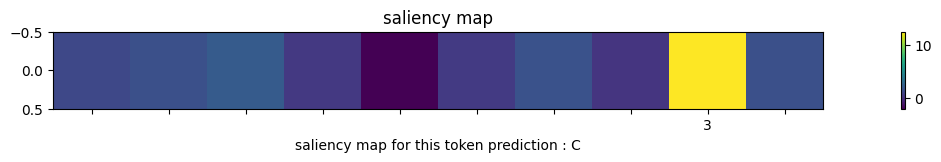

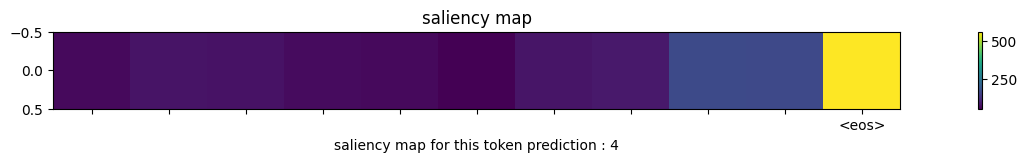

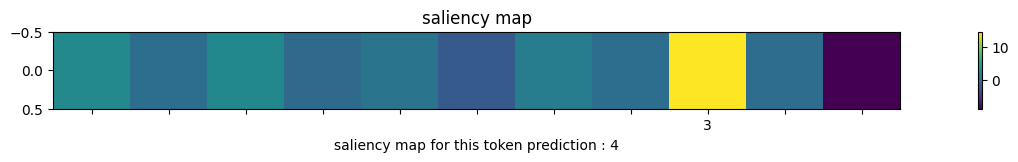

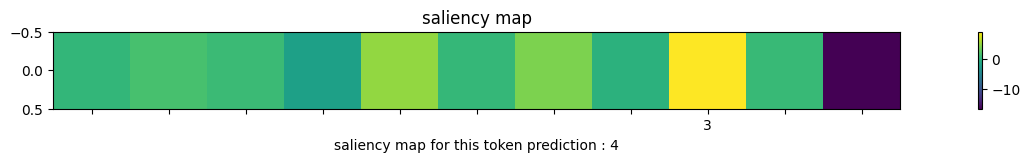

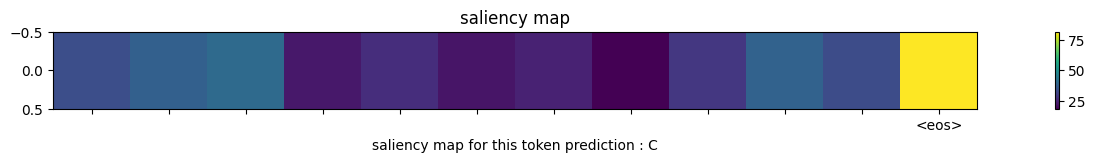

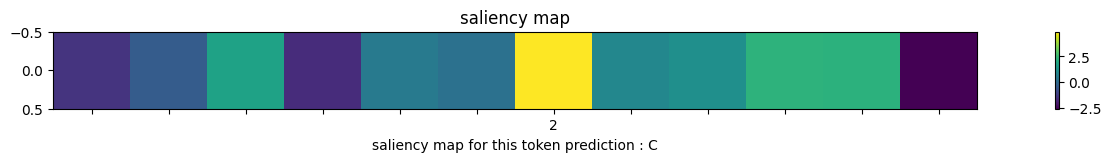

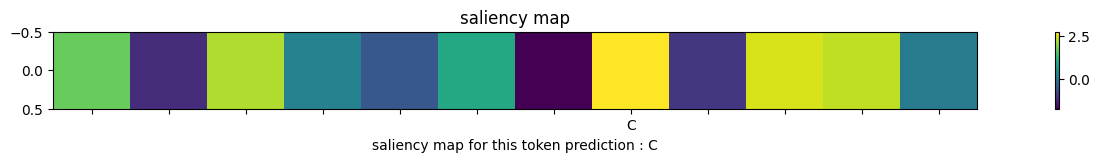

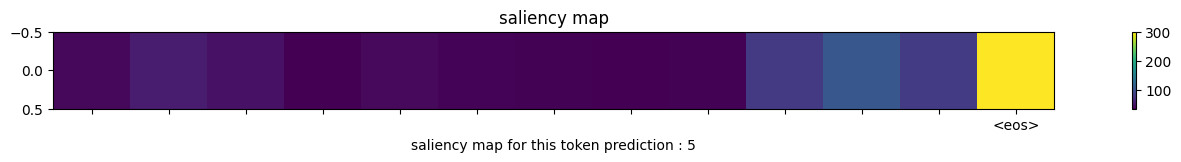

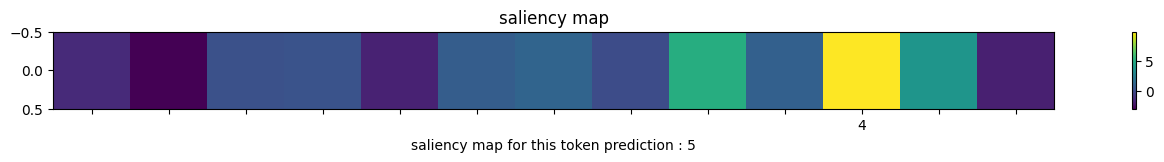

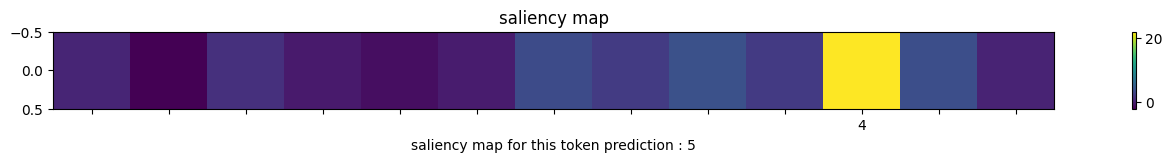

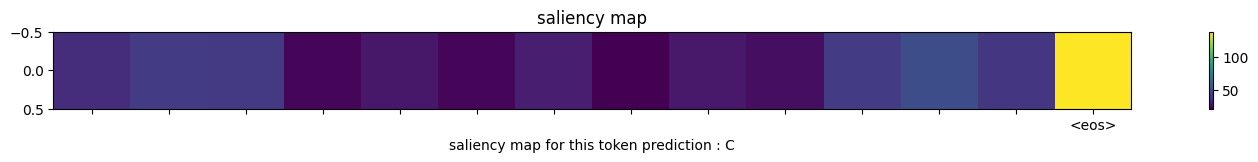

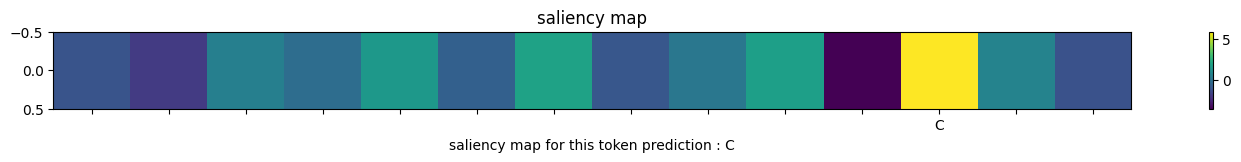

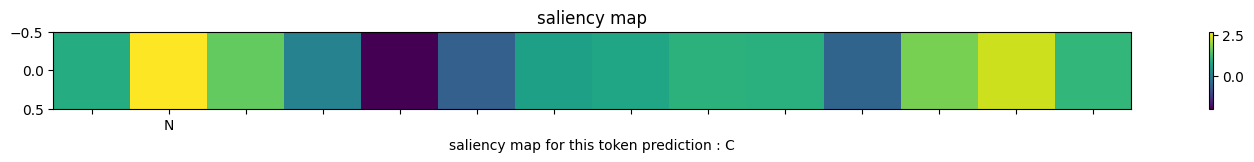

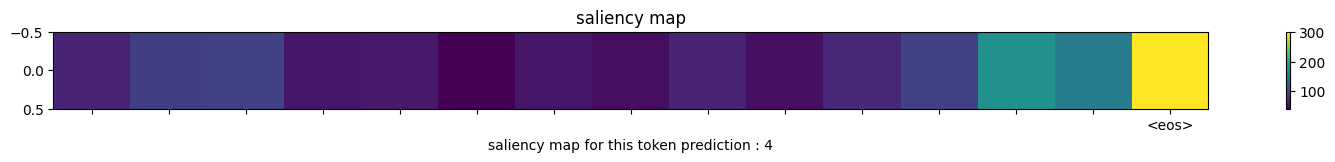

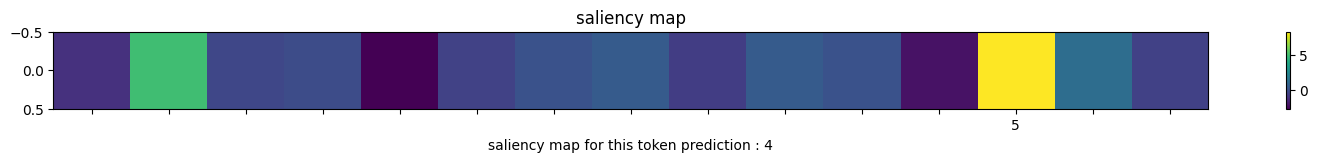

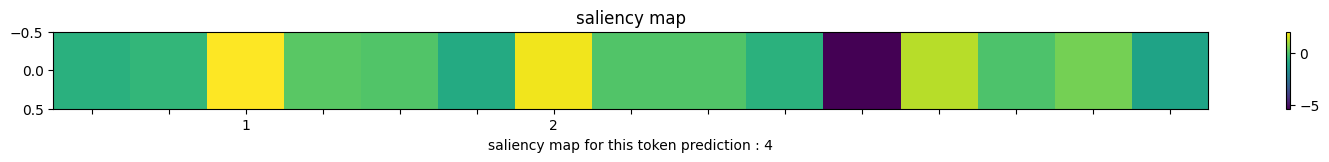

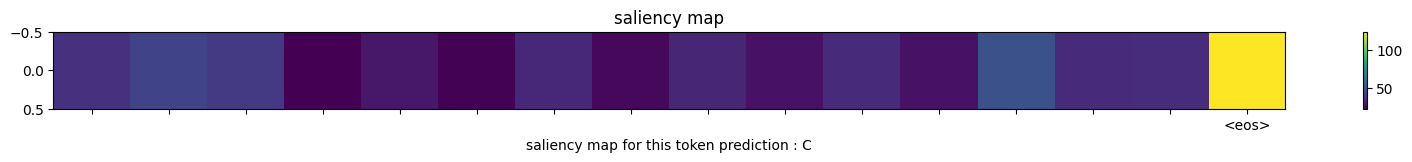

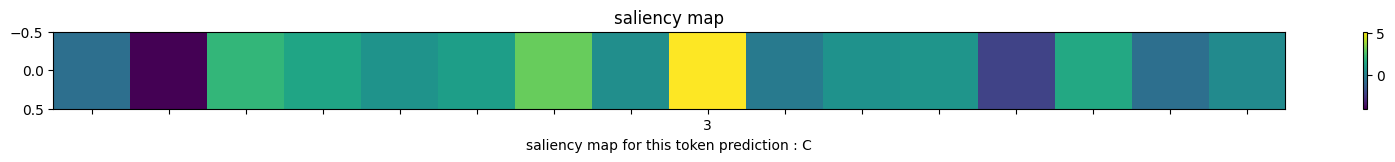

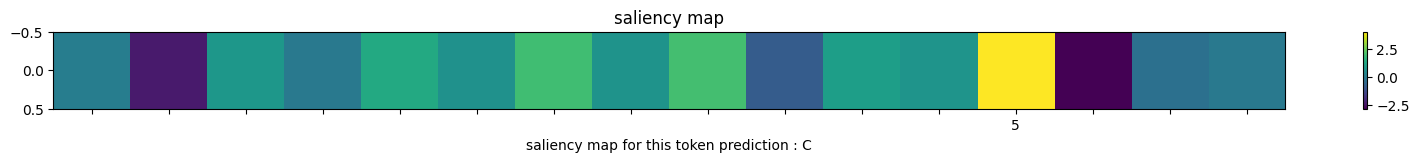

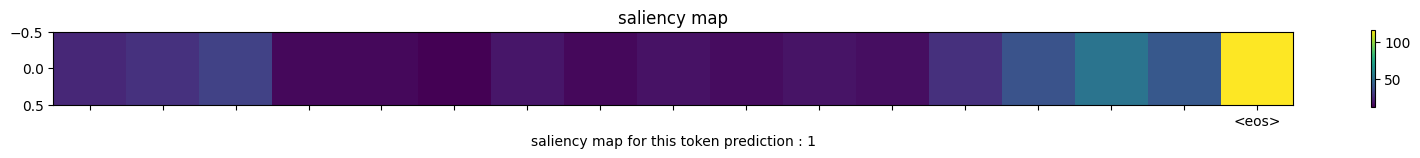

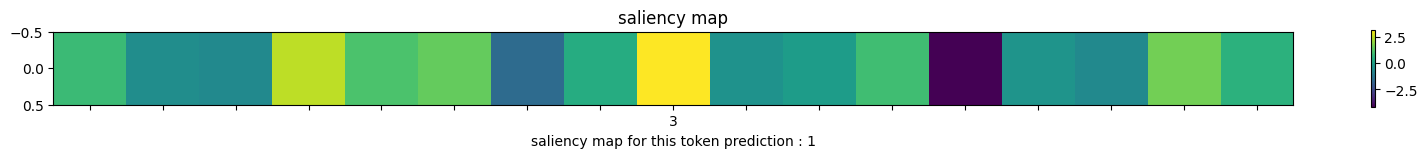

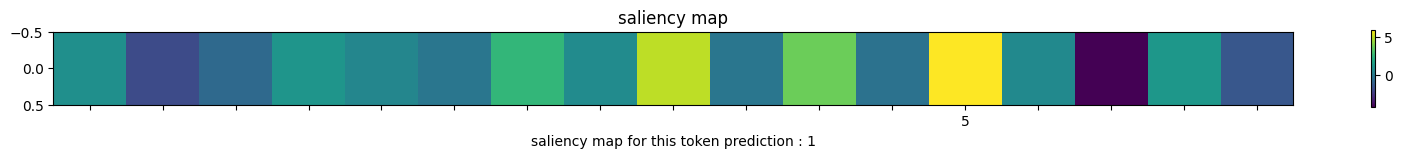

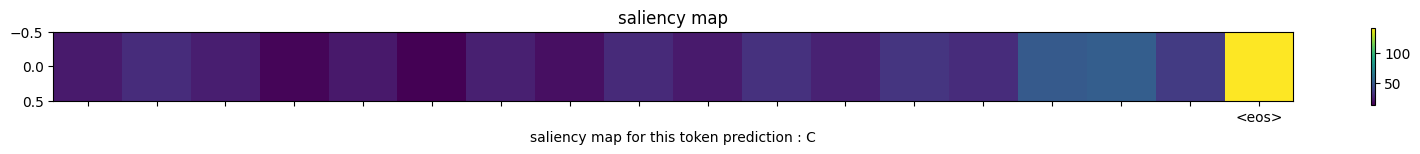

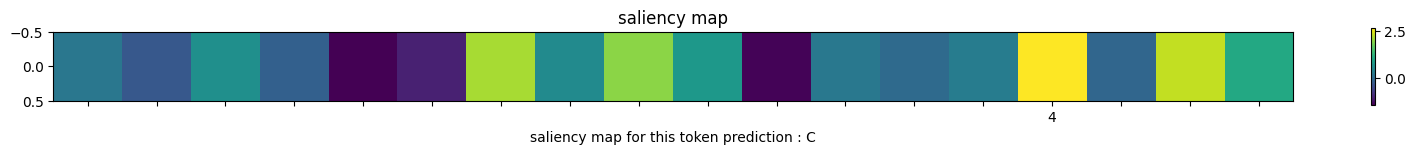

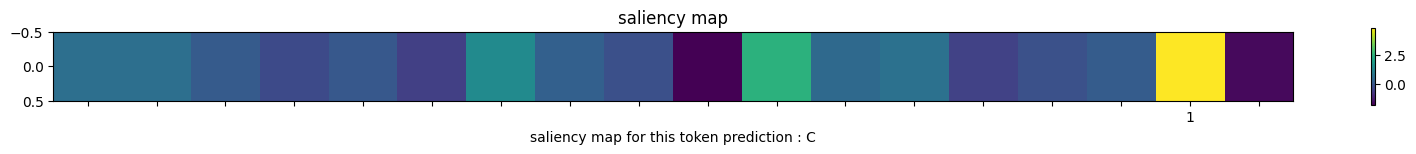

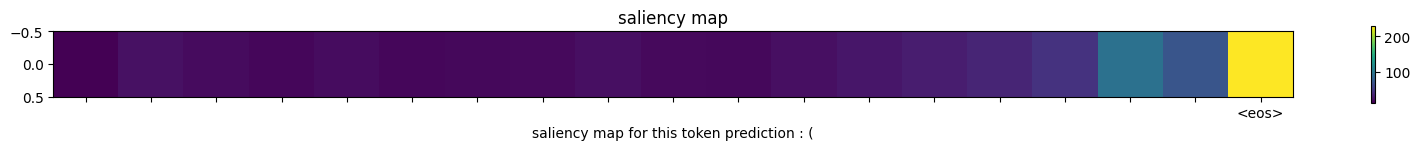

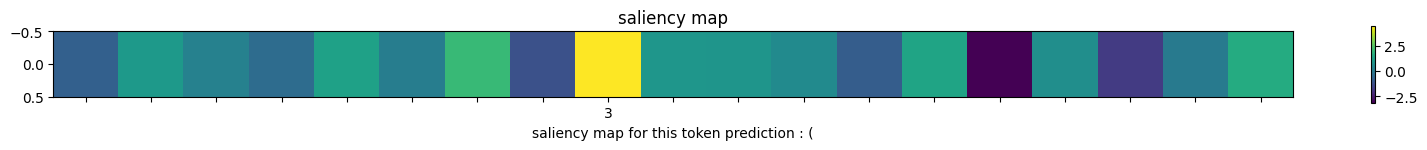

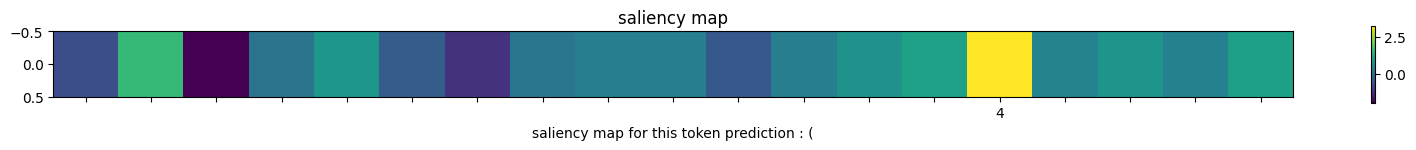

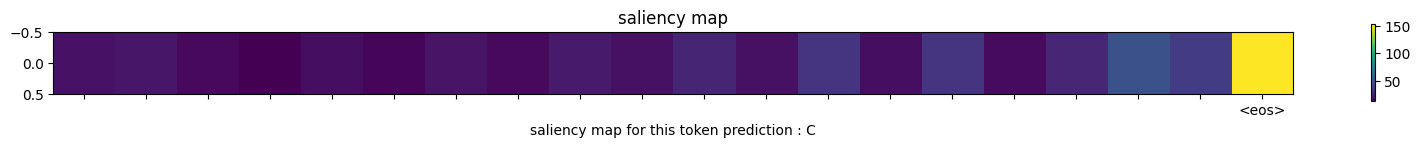

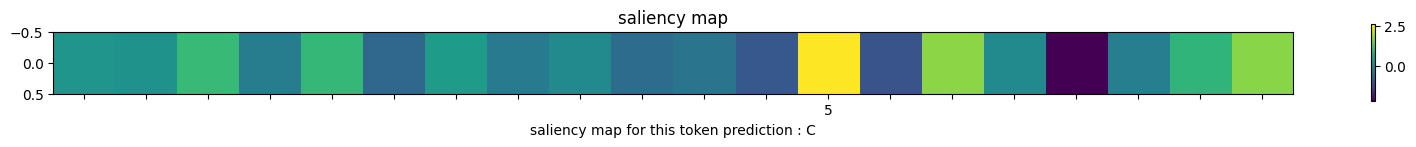

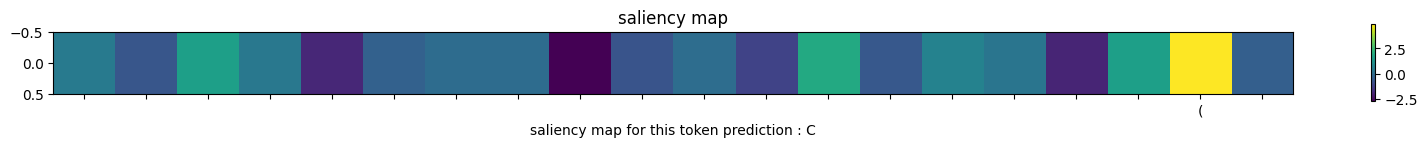

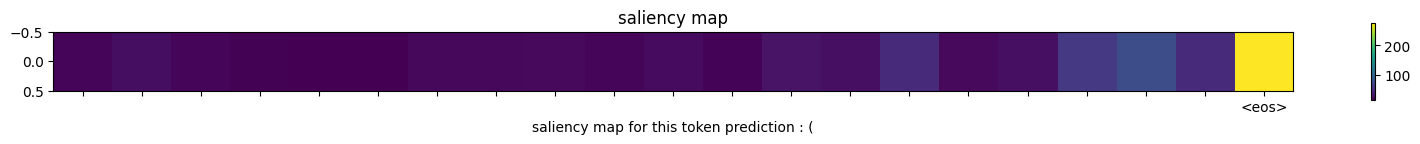

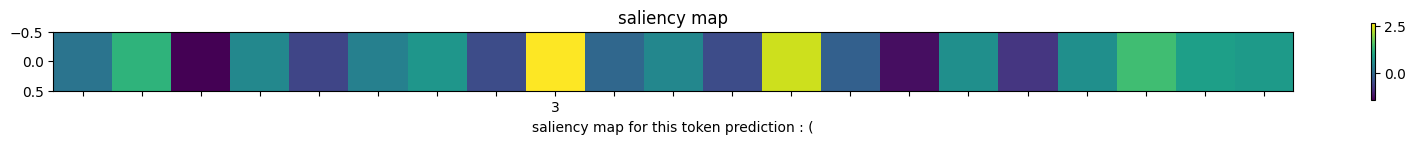

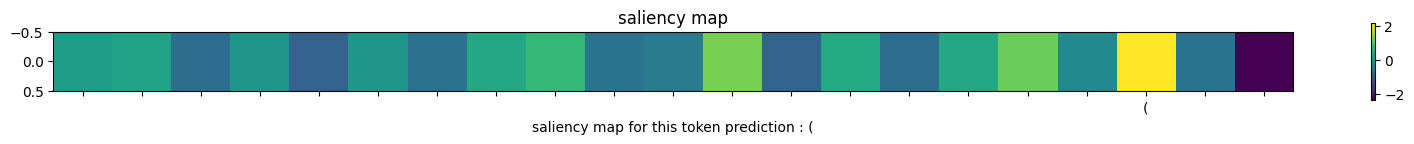

In [23]:

prompt = ""
ig = IntegratedGradients(forward_func)
saliency = Saliency(forward_func)
gradient_shap = GradientShap(forward_func)
deep_lift = DeepLift(forward_func)
baselines = ['zero', 'random']

results = {}
for k in range(20):
    results[k] = {}
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]
    inputs_embeds = model.transformer.wte(input_ids)
    #print(inputs_embeds.shape)
    #print(inputs_embeds.shape)
    inputs_embeds.requires_grad_()
    #prédiction du token suivant
    sf = torch.nn.Softmax(1)
    sf2 = torch.nn.Softmax(0)
    with torch.no_grad():
        out = model(input_ids=input_ids)
        #print(out.logits.shape)
        #probabilities = probabilities[0].tolist()
        #print(probabilities)
        #aléatoire et non déterministe (on prend pas le max mais on choisit une certaine distribution)
        probabilities = sf(out.logits[:, -1, :])
        pred_token_id = probabilities.multinomial(num_samples=1, replacement=True).item()
        #pred_token_id = torch.argmax(out.logits[:, -1, :], dim=-1).item()
        #print(pred_token_id)
        pred_token = tokenizer.decode([pred_token_id], skip_special_tokens=True)
        #print(f"Token prédit : '{pred_token}'")
        prompt += pred_token



    
        attributions = saliency.attribute(inputs_embeds, target=pred_token_id, abs=True)
        # 7. Affichage des scores par token
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
        scores = attributions.sum(dim=-1).squeeze()# on somme sur les dimensions d'embedding
        results[k]['Saliency'] = scores.detach()


        for baseline_method in baselines:
                baseline = compute_baseline_embeddings(inputs_embeds, baseline_method)
                
                ig_attr = ig.attribute(
                    inputs_embeds, 
                    baselines=baseline,
                    target=pred_token_id,
                    n_steps=50,  # Nombre d'étapes d'intégration
                    internal_batch_size=1
                )
                ig_scores = ig_attr.sum(dim=-1).squeeze()
                results[k][f'IntegratedGradients_{baseline_method}'] = ig_scores.detach()

        n_samples = 10
        baselines_random = torch.randn(n_samples, *inputs_embeds.shape[1:]) * 0.1
        
        try:
            gs_attr = gradient_shap.attribute(
                inputs_embeds,
                baselines=baselines_random,
                target=pred_token_id,
                n_samples=n_samples,
                stdevs=0.1
            )
            gs_scores = gs_attr.sum(dim=-1).squeeze()
            results[k]['GradientShap'] = gs_scores.detach()
        except Exception as e:
            print(f"Erreur GradientShap: {e}")
            results[k]['GradientShap'] = None

        try:
            
            baseline_zero = compute_baseline_embeddings(inputs_embeds, 'zero')
            
            dl_attr = deep_lift.attribute(
                inputs_embeds,
                baselines=baseline_zero,
                target=pred_token_id
            )
            dl_scores = dl_attr.sum(dim=-1).squeeze()
            results['DeepLift'] = dl_scores.detach()
        except Exception as e:
            #print(f"Erreur DeepLift: {e}")
            results['DeepLift'] = None


    #print(scores)
    #scores = sf2(scores)
    #print(attributions.shape)
    #print(scores.shape)
    #print("saliency")
    saliency_map_plot(scores, tokens,pred_token=pred_token)
    
    try:
        #print("integrated gradient")
        saliency_map_plot(ig_scores, tokens,pred_token=pred_token)
    except Exception as e:
         print(f"Erreur : {e}")
    try:
        #print("gradient shape")
        saliency_map_plot(gs_scores, tokens,pred_token=pred_token)
    except Exception as e:
         print(f"Erreur : {e}")
    try:
        saliency_map_plot(dl_scores, tokens,pred_token=pred_token)
    except Exception as e:
         print(f"Erreur : {e}")


TypeError: saliency_map_plot() missing 2 required positional arguments: 'tokens' and 'pred_token'

In [36]:
print(len(prompt))
prompt

16


'C1CCCC(C(Cccc2cn'

In [6]:
generated_ids = model.generate(
    max_length = tokenizer.model_max_length,
    num_return_sequences =1,
    pad_token_id = tokenizer.pad_token_id,
    bos_token_id = tokenizer.bos_token_id,
    eos_token_id = tokenizer.eos_token_id,
    do_sample = True,
    temperature = 1,
    return_dict_in_generate = True,
)

generated_smiles = tokenizer.decode(generated_ids["sequences"][0],skip_special_tokens=True)
len(generated_ids["sequences"])
generated_smiles = generated_smiles.replace(" ","")
generated_smiles

'CC(=O)OC(C(=O)Nc1cc(Cl)ccc1O)c1ccccc1'

In [7]:
def saliency_map_plot(scores,tokens,pred_token): 
    

    max_score = torch.max(scores).item()  
    token_max_score_idx = []
    for k in range(len(scores)):
        if scores[k] >= 0*max_score:
            token_max_score_idx.append(k)
    tokens_adapted = ["" if k not in token_max_score_idx else tokens[k] for k in range(len(tokens)) ]
    fig, ax = plt.subplots(figsize=(20, 1))
   
    im = ax.imshow([scores.tolist()],cmap="viridis", data=tokens)
    ax.set_title('saliency map')
    fig.colorbar(im)

    plt.xticks([k for k in range(len(scores.tolist()))], tokens_adapted)

    ax.set_xlabel("saliency map for this token prediction : "+pred_token)

    

    
# 4. Forward personnalisé : utilise les embeddings au lieu de input_ids
def forward_func(embeds):
    outputs = model(inputs_embeds=embeds)
    # Prédiction du prochain token (dernier logit)
    return outputs.logits[:, -1, :]  # shape [1, vocab_size]


5
['C', 'C', '(', '=', 'O']
[36, 36, 113, 37, 74]
32
[32, 36, 36, 113, 37, 74]
torch.Size([1, 6, 150])
)
torch.Size([6])
6
CC(=O)OC(C(=O)Nc1cc(Cl)ccc1O)c1ccccc1


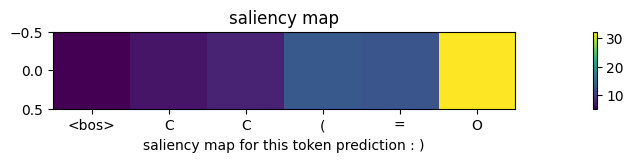

In [8]:

inputs_tokens = tokenizer.tokenize(generated_smiles, return_tensors="pt")


count = 0
for k in range(len(inputs_tokens)):
    if inputs_tokens[k] == ")":
        idx =k
        print(idx)
        count +=1
        if count == 1:
            break
        
        


sliced_inputs_tokens = inputs_tokens[:idx]
print(sliced_inputs_tokens)

inputs_ids = tokenizer.convert_tokens_to_ids(sliced_inputs_tokens)
begin = tokenizer.convert_tokens_to_ids("<bos>")
print(inputs_ids)
print(begin)
inputs_ids.insert(0,begin)
print(inputs_ids)

inputs_embeds = model.transformer.wte(torch.tensor([inputs_ids]))
custom_attention_mask = torch.tensor([[1]*(idx+1)])

#print(idx)
inputs_ids = torch.tensor([inputs_ids])
    #print(inputs_embeds.shape)
inputs_embeds.requires_grad_()
    #prédiction du token suivant
sf = torch.nn.Softmax(1)
sf2 = torch.nn.Softmax(0)


with torch.no_grad():
    out = model(input_ids=inputs_ids,attention_mask=custom_attention_mask)
    print(out.logits.shape)
    probabilities = sf(out.logits[:, -1, :])
    #print(out.logits.shape)
    #print(probabilities.shape)
    pred_token_id = probabilities.multinomial(num_samples=1, replacement=True).item()
    #pred_token_id = torch.argmax(out.logits[:, -1, :], dim=-1).item()
    
    print(tokenizer.convert_ids_to_tokens(pred_token_id))

    target_ids = tokenizer.convert_tokens_to_ids(")")
    

    saliency = Saliency(forward_func)
    attributions = saliency.attribute(inputs_embeds, target=target_ids, abs=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs_ids[0])
  
    scores = attributions.sum(dim=-1).squeeze()
    print(scores.shape)
    print(len(tokens))
    saliency_map_plot(scores, tokens,pred_token=")")
    print(generated_smiles)


In [239]:
scores.argmax()
tokens[scores.argmax()]

'O'

In [7]:
import pandas as pd 

benchmark = pd.read_csv("../reports/data/BENCHMARK/BENCHMARK_can_smiles_moses_CL.csv")
benchmark

,valid,unique@1000,unique@10000,FCD/Test,SNN/Test,Frag/Test,Scaf/Test,FCD/TestSF,SNN/TestSF,Frag/TestSF,...,IntDiv,IntDiv2,Filters,logP,SA,QED,weight,Novelty,model_name,sample length
0,0.994600,1.000,0.999296,0.151123,0.633489,0.999580,0.874585,0.643927,0.584651,0.997869,...,0.855816,0.849658,0.997587,0.023921,0.012648,0.001544,2.638526,0.718483,MolGPT_moses_canonical_characterlevel_5_0,10000
1,0.993699,1.000,0.998893,0.147796,0.634377,0.999518,0.880716,0.658112,0.584858,0.997782,...,0.855719,0.849559,0.997987,0.021485,0.005964,0.000756,2.158175,0.723801,MolGPT_moses_canonical_characterlevel_5_1,9998
2,0.993300,1.000,0.998691,0.157666,0.633981,0.999528,0.870124,0.636646,0.585291,0.997898,...,0.855388,0.849270,0.998087,0.024118,0.009076,0.001398,2.475751,0.717036,MolGPT_moses_canonical_characterlevel_5_2,10000
3,0.994400,1.000,0.998994,0.153021,0.632332,0.999598,0.871703,0.632665,0.583718,0.997840,...,0.855576,0.849427,0.997888,0.023825,0.009952,0.001117,2.736587,0.717536,MolGPT_moses_canonical_characterlevel_5_3,10000
4,0.993400,1.000,0.999195,0.146049,0.633550,0.999599,0.874133,0.634626,0.584709,0.998046,...,0.856071,0.849929,0.998591,0.024711,0.004143,0.001531,2.492537,0.726274,MolGPT_moses_canonical_characterlevel_5_4,10000
5,0.993200,0.999,0.999497,0.148941,0.632401,0.999444,0.881030,0.657821,0.583102,0.997689,...,0.855920,0.849776,0.997785,0.028579,0.006830,0.001240,2.480409,0.725698,MolGPT_moses_canonical_characterlevel_5_5,10000
6,0.994200,1.000,0.999200,0.109352,0.633398,0.999621,0.910442,0.592658,0.584527,0.997713,...,0.855093,0.849053,0.997854,0.021228,0.007318,0.001531,2.648687,0.715514,MolGPT_moses_canonical_characterlevel_5_all,15000
7,1.000000,1.000,1.000000,0.008000,0.475500,0.641900,0.585900,1.000000,0.998600,0.990700,...,0.856700,0.850800,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,moses original database,1500000


In [1]:
import pandas as pd 

benchmark = pd.read_csv("../reports/data/BENCHMARK/BENCHMARK.csv")
benchmark

,valid,unique@1000,unique@10000,FCD/Test,SNN/Test,Frag/Test,Scaf/Test,FCD/TestSF,SNN/TestSF,Frag/TestSF,...,IntDiv,IntDiv2,Filters,logP,SA,QED,weight,Novelty,model_name,sample length
0,0.984700,0.998,0.986595,0.729370,0.644139,0.995622,0.868169,1.429713,0.586570,0.993097,...,0.848716,0.842409,0.997867,0.037655,0.080440,0.006012,3.601202,0.702419,MolGPT_moses_canonical_BEP_1,10000
1,0.984700,0.998,0.986595,0.729370,0.644139,0.995622,0.868169,1.429713,0.586570,0.993097,...,0.848716,0.842409,0.997867,0.037655,0.080440,0.006012,3.601202,0.702419,MolGPT_moses_canonical_BEP_1,10000
2,0.505600,0.999,0.968552,1.951002,0.626165,0.986948,0.819002,2.908482,0.575345,0.982219,...,0.845867,0.838781,0.988528,0.059129,0.090966,0.006785,7.787214,0.752706,MolGPT_moses_canonical_BEP_2,10000
3,0.995067,1.000,0.984300,0.874315,0.655003,0.995085,0.825630,1.465010,0.599806,0.993734,...,0.847865,0.841429,0.998660,0.062925,0.067048,0.001915,3.992824,0.669116,MolGPT_moses_clearSMILES_BEP_1,10000
4,0.930400,1.000,0.998900,0.124180,0.623745,0.999600,0.894959,0.589369,0.578767,0.998211,...,0.856505,0.850439,0.997277,0.028681,0.007708,0.002084,1.775489,0.778719,MolGPT_moses_canonical_characterlevel_1,10000
5,0.967800,0.999,0.985224,2.327680,0.438432,0.981862,0.470149,2.600068,0.426977,0.979552,...,0.871236,0.865792,0.969725,0.321289,0.486142,0.043910,6.837731,0.993288,Etienne_VAE_moses_clearSMILES_latent15,10000
6,0.980200,0.999,0.984493,1.628860,0.460908,0.994590,0.631700,1.927573,0.448651,0.992370,...,0.864347,0.858773,0.968578,0.255248,0.345793,0.021955,7.375981,0.991399,Etienne_VAE_moses_clearSMILES_latent22,10000
7,0.967700,0.998,0.981300,2.234347,0.437353,0.981481,0.584480,2.507678,0.426110,0.979343,...,0.871757,0.866447,0.967707,0.336652,0.492918,0.045777,7.170232,0.995510,Etienne_VAE_moses_clearSMILES_latent15,20000
8,0.967800,0.999,0.983400,2.218422,0.438963,0.983710,0.524396,2.506241,0.427091,0.981045,...,0.871674,0.866267,0.967762,0.335964,0.489980,0.044099,6.891819,0.994987,Etienne_VAE_moses_clearSMILES_latent15,15000
9,0.976800,1.000,0.984100,1.521695,0.463672,0.994274,0.675851,1.825835,0.450950,0.992138,...,0.863962,0.858449,0.966284,0.259828,0.339893,0.021151,7.124472,0.991395,Etienne_VAE_moses_clearSMILES_latent22,15000


In [ ]:
model_name = "Train"
valid =1.0 	
unique = 1.0 	
unique10000 = 1.0 	
fcd_test = 0.008 
fcd_sf = 0.4755 	
Snn_test =0.6419 	
Snn_testsf =0.5859 
frag_test = 1.0 	
frag_testsf = 0.9986 	
scaf_test = 0.9907 
scaf_testsf = 0.0 	
intdiv1 = 0.8567 	
intdiv2 = 0.8508 	
filters = 1.0 	
novelty = 1.0

In [6]:

benchmark = pd.read_csv("../reports/data/BENCHMARK/BENCHMARK_MOSES_BPE.csv")
benchmark

,valid,unique@1000,unique@10000,FCD/Test,SNN/Test,Frag/Test,Scaf/Test,FCD/TestSF,SNN/TestSF,Frag/TestSF,...,IntDiv,IntDiv2,Filters,logP,SA,QED,weight,Novelty,model_name,sample length
0,0.990533,0.998,0.9742,0.750436,0.654277,0.992275,0.839016,1.281797,0.595267,0.990825,...,0.849698,0.843212,0.998519,0.108396,0.056367,0.004155,6.489241,0.633518,MolGPT_moses_clearSMILES_BEP_3,15000
1,0.802933,0.995,0.9527,0.891895,0.638519,0.990055,0.854501,1.609346,0.584627,0.986169,...,0.850368,0.843660,0.986134,0.297463,0.060374,0.004715,13.189916,0.698903,MolGPT_moses_canonical_BEP_3,15000
2,1.000000,1.000,1.0000,0.008000,0.475500,0.641900,0.585900,1.000000,0.998600,0.990700,...,0.856700,0.850800,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,moses train,1500000


In [58]:
def detect_molcl(s):
    return("MolGPT_moses_canonical_characterlevel_5" in s)

In [65]:

benchmark["ismolcl"] = benchmark["model_name"].apply(detect_molcl)

In [66]:
benchmark[benchmark["ismolcl"] ]

,valid,unique@1000,unique@10000,FCD/Test,SNN/Test,Frag/Test,Scaf/Test,FCD/TestSF,SNN/TestSF,Frag/TestSF,...,IntDiv2,Filters,logP,SA,QED,weight,Novelty,model_name,sample length,ismolcl
35,0.994600,1.0,0.999296,0.151123,0.633489,0.999580,0.874585,0.643927,0.584651,0.997869,...,0.849658,0.997587,0.023921,0.012648,0.001544,2.638526,0.718483,MolGPT_moses_canonical_characterlevel_5,10000,True
36,0.902476,1.0,0.999000,1.427183,0.555088,0.987239,0.574693,1.793111,0.521307,0.989147,...,0.870195,0.986330,0.121603,0.223871,0.024991,2.780068,0.870100,MolGPT_moses_canonical_characterlevel_5_temper...,11997,True
37,0.998667,1.0,0.996600,0.679949,0.662316,0.995803,0.903592,1.264963,0.604812,0.992633,...,0.837102,0.999499,0.056225,0.087957,0.012715,3.353591,0.646202,MolGPT_moses_canonical_characterlevel_5_temper...,12000,True


In [9]:
benchmark[benchmark["valid"]==0.932800]["Scaf/TestSF"]

15    0.071817
Name: Scaf/TestSF, dtype: float64

In [10]:
benchmark[benchmark["valid"]==0.932800]["Scaf/Test"]

15    0.8513
Name: Scaf/Test, dtype: float64

In [18]:
benchmark[benchmark["valid"]==0.932800]["IntDiv"]

15    0.856033
Name: IntDiv, dtype: float64

In [ ]:
benchmark[benchmark["valid"]==0.932800]

,valid,unique@1000,unique@10000,FCD/Test,SNN/Test,Frag/Test,Scaf/Test,FCD/TestSF,SNN/TestSF,Frag/TestSF,...,IntDiv2,Filters,logP,SA,QED,weight,Novelty,model_name,sample length,ismolcl
15,0.9328,1.0,0.99925,0.170832,0.625428,0.99945,0.8513,0.579517,0.581231,0.998109,...,0.849852,0.997856,0.025051,0.006335,0.001485,1.549301,0.77717,MolGPT_moses_canonical_characterlevel_1,10000,True


In [16]:
benchmark.sort_values(by="Novelty")[benchmark["ismolcl"]]

/tmp/ipykernel_2649475/2806903151.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  benchmark.sort_values(by="Novelty")[benchmark["ismolcl"]]


,valid,unique@1000,unique@10000,FCD/Test,SNN/Test,Frag/Test,Scaf/Test,FCD/TestSF,SNN/TestSF,Frag/TestSF,...,IntDiv2,Filters,logP,SA,QED,weight,Novelty,model_name,sample length,ismolcl
24,1.0,1.0,0.999310,2.258069,0.523043,0.875728,0.532498,2.643211,0.497891,0.881038,...,0.863139,0.962032,0.283829,0.335036,0.112161,3.704692,1.0,MolGPT_moses_canonical_characterlevel_1_withou...,7243,True
25,1.0,1.0,0.999753,2.874449,0.520051,0.857316,0.466756,3.439072,0.492818,0.861901,...,0.857196,0.947914,0.354123,0.343693,0.116228,10.545504,1.0,MolGPT_moses_ClearSMILES_characterlevel_1_with...,4051,True


In [18]:
DATA = pd.read_csv("../data/training_data/moses_canonical.csv")

len(DATA[DATA["SPLIT"]=="test"]["SPLIT"].to_list()) / len(DATA["SPLIT"].to_list())

0.09090214469876022

In [19]:
len(DATA[DATA["SPLIT"]=="train"]["SPLIT"].to_list()) / len(DATA["SPLIT"].to_list())

0.8181177534716737

In [20]:
len(DATA[DATA["SPLIT"]=="test_scaffolds"]["SPLIT"].to_list()) / len(DATA["SPLIT"].to_list())

0.09098010182956609

In [21]:
DATA = pd.read_csv("../data/training_data/guacamol_canonical.csv")

len(DATA[DATA["SPLIT"]=="test"]["SPLIT"].to_list()) / len(DATA["SPLIT"].to_list())

0.10008935651994687

In [22]:
len(DATA[DATA["SPLIT"]=="test_scaffolds"]["SPLIT"].to_list()) / len(DATA["SPLIT"].to_list())

0.09989581356535028

In [23]:
len(DATA[DATA["SPLIT"]=="train"]["SPLIT"].to_list()) / len(DATA["SPLIT"].to_list())

0.8000148299147029